### Sentiment Classification experiment

#### Objectives:
1. Ideally, a sentiment classifier should assign a neutral sentiment to a persons name. Jack should not be classified any more positive sentiment than say, Lamar.
2. This is not what we observe with standard trained deep neural networks though
3. In this notebook, we first show that models trained in a standard manner assign positive sentiment to predominantly European-American names as compared to predominantly African-American names.
4. We then train the same model using Individual Fairness, to reduce this sentiment gap between names from different ethnicities.


#### Steps:
1. Download data from http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar into the `data` folder
2. Extract the contents of the rar file into the `data/opinion-lexicon-English` folder
3. Download the Common Crawl (42B tokens) GloVe word embeddings from https://nlp.stanford.edu/projects/glove/ and place in the `data/embeddings` folder
4. Download the NYC Popular Baby names from https://data.cityofnewyork.us/w/25th-nujf/25te-f2tw?cur=2SqHSlbYnOB&from=root in the folder `data/names`

In [1]:
# uncomment and install dependencies before continuing
#!pip install inFairness matplotlib seaborn tqdm

### Step 1: We start the experiment by importing relevant PyTorch and inFairness packages. 
 
- From inFairness, we only need the SenSeI fair algorithm, and the distances module

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

from inFairness.fairalgo import SenSeI
from inFairness import distances
from inFairness.auditor import SenSRAuditor

import pandas as pd
# Import data loading script
%load_ext autoreload
%autoreload 2
import data

### Step 2: Loading the data

1. We require the GloVe 42B token word embeddings to embed our names
2. The `opinion=lexicon-English` data will serve as our training data with examples of positive and negative sentiment words, and
3. The `NYC popular baby names` will be used by the inFairness distance metric to ignore the name subspace

In [4]:
DATAPATH = 'data/opinion-lexicon-English'
EMBEDPATH = 'data/embeddings/glove.42B.300d.txt'
NYC_NAMES_PATH = 'data/names/Popular_Baby_Names.csv'


# Load data and embeddings
embeddings, X_train, X_test, y_train, y_test, train_vocab, test_vocab = data.load_data(DATAPATH, EMBEDPATH)

# Load test names and their embeddings
test_df, test_names_embed = data.load_test_names(embeddings)

# Load popular NYC Baby names and their embeddings
# This data is used to train the subspace robustness metric
nyc_names_embed = data.load_nyc_names(NYC_NAMES_PATH, embeddings)

While our training data contains words with positive and negative sentiments, we use two test datasets:

1. The first test dataset is a collection of a broader set of words that we will use to compute accuracy, and
2. A set of names along with the race and gender they are predominantly associated with. Utilizing the race and gender will allow us to study the performance of the sentiment classifier for these different groups.

In [5]:
print(f'Test set used for accuracy computation is of size: {y_test.shape}')
print(f'Test set with names and associated race and gender is of size: {len(test_df)}')
print('Some samples from the names test set are:')
test_df.head()

Test set used for accuracy computation is of size: (663,)
Test set with names and associated race and gender is of size: 94
Some samples from the names test set are:


,name,race,gender
0,adam,White,Male
1,chip,White,Male
2,harry,White,Male
3,josh,White,Male
4,roger,White,Male


### Step 3: Let's create our PyTorch dataloader and also create a 2-layer fully connected neural network

In [6]:
class SentimentDataset(Dataset):
    def __init__(self, data, labels):
        
        self.data = data
        self.labels = labels

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]
        return data, label

    def __len__(self):
        return len(self.labels)


# Create the training and testing dataset
train_ds = SentimentDataset(X_train, y_train)
test_ds = SentimentDataset(X_test, y_test)

# Create train and test dataloaders
train_dl = DataLoader(train_ds, batch_size=64)
test_dl = DataLoader(test_ds, batch_size=1000)

In [7]:
# Create a 2-layer fully connected neural network

class Model(nn.Module):

    def __init__(self):

        super().__init__()
        self.fc1 = nn.Linear(300, 1000)
        self.fcout = nn.Linear(1000, 2)

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = self.fcout(x)
        return x

### Step 4: Let's train a sentiment classifier in a standard manner, and evaluate it's accuracy

In [8]:
device = torch.device("cpu")

network_standard = Model().to(device)
optimizer = torch.optim.Adam(network_standard.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

EPOCHS = 50

In [9]:
network_standard.train()

for epoch in tqdm(range(EPOCHS)):

    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = network_standard(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

  0%|          | 0/50 [00:00<?, ?it/s]

In [10]:
# Evaluate the model by computing its accuracy
network_standard.eval()

corr, total = 0, 0

for x, y in test_dl:
    x = x.to(device)
    y_pred = network_standard(x)
    y_pred = torch.argmax(y_pred.detach().cpu(), dim=-1)

    total += y.shape[0]
    corr += (y == y_pred).sum().numpy()

acc = corr * 100.0/float(total)
print(f'Accuracy: {acc}')

Accuracy: 93.81598793363499


#### The sentiment classifier network achieves ~94% accuracy, which is impressive. However, when analyzed for variances in prediction between races and genders, the model presents glaring differences.

- Let's evaluate the difference in sentiment scores for predominantly white and black names, and male and female names

baseline test accuracy 93.815988
baseline Black mean sentiment is 0.350054
baseline White mean sentiment is 0.832151
baseline race mean sentiment difference is 0.482097

baseline Female mean sentiment is 0.728495
baseline Male mean sentiment is 0.479522
baseline gender mean sentiment difference is 0.248973



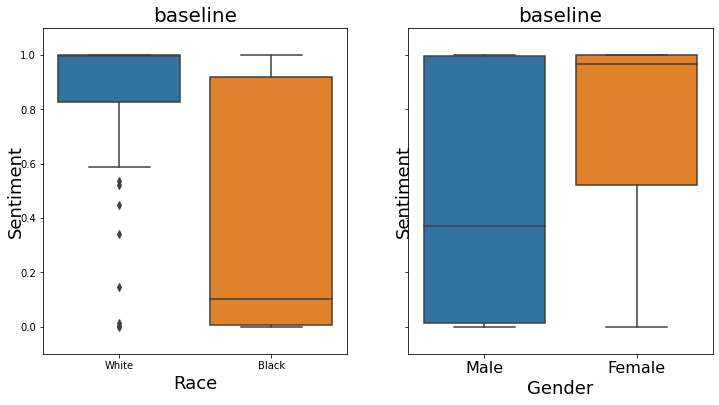

In [11]:
test_names_embed_torch = torch.FloatTensor(test_names_embed).to(device)

test_logits = network_standard(test_names_embed_torch)
test_logits = F.softmax(test_logits, dim=-1)
test_logits = test_logits.data.cpu().numpy()

test_df['baseline_logits'] = test_logits[:, 1]# - test_logits[:, 0]

data.print_summary(test_df, 'baseline', acc)

#### Now let's experiment with how the sentiment changes for sentences with different cuisines and names. Notice that while the only words changing between sentences are the cuisine and name, the sentiment of the sentence varies significantly.

In [12]:
sentences = ["Let's go get Italian food", "Let's go get Chinese food", "Let's go get Mexican food"]

for sentence in sentences:
    sentiment  = data.text_to_sentiment(sentence, network_standard, embeddings, device)
    print(f'{sentence} --> {data.format_sentiment_score(sentiment)}')

Let's go get Italian food --> Positive with score 99.86%
Let's go get Chinese food --> Positive with score 98.78%
Let's go get Mexican food --> Positive with score 91.20%


In [13]:
sentences = ["My name is Emily", "My name is Heather", "My name is Yvette", "My name is Shaniqua"]

for sentence in sentences:
    sentiment  = data.text_to_sentiment(sentence, network_standard, embeddings, device)
    print(f'{sentence} --> {data.format_sentiment_score(sentiment)}')

My name is Emily --> Positive with score 99.74%
My name is Heather --> Positive with score 99.61%
My name is Yvette --> Positive with score 97.40%
My name is Shaniqua --> Positive with score 74.81%


## Step 5: Now let's train a fair neural network using the SenSeI fair algorithm

- To train a fair model with SenSeI, we need to define the distance metrics in the input and output spaces:
    - In the input space, we define `distance_x` to be the `SVDSensitiveSubspaceDistance` metric, which given a list of names will learn to ignore this sensitive subspace
    - In the output space, we define `distance_y` to be the Eucliden distance between data points
- For the fair algorithm, we use the SenSeI algorithm

In [14]:
network_fair = Model().to(device)
optimizer = torch.optim.Adam(network_fair.parameters(), lr=1e-3)
lossfn = F.cross_entropy

distance_x = distances.SVDSensitiveSubspaceDistance()
distance_y = distances.EuclideanDistance()

In [15]:
distance_x.fit(X_train=nyc_names_embed, n_components=50)
distance_y.fit()

distance_x.to(device)
distance_y.to(device)

EuclideanDistance()

In [16]:
rho = 5.0
eps = 0.1
auditor_nsteps = 25
auditor_lr = 0.1

fairalgo = SenSeI(network_fair, distance_x, distance_y, lossfn, rho, eps, auditor_nsteps, auditor_lr)

#### Having defined the fair algorithm, we use the fairalgo object to train the model. The only change here is to use the `fairalgo` object to do the forward and backward pass. The rest of the training loop remains the same

In [17]:
fairalgo.train()

EPOCHS = 50

for epoch in tqdm(range(EPOCHS)):
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        result = fairalgo(x, y)
        result.loss.backward()
        optimizer.step()

  0%|          | 0/50 [00:00<?, ?it/s]

In [18]:
# Evaluate the model accuracy

fairalgo.eval()

corr, total = 0, 0

for x, y in test_dl:
    x, y = x.to(device), y.to(device)
    result = fairalgo(x)
    y_pred = result.y_pred
    y_pred = torch.argmax(y_pred, dim=-1)

    total += y.shape[0]
    corr += (y == y_pred).sum().cpu().numpy()

acc = corr * 100.0/float(total)
print(f'Accuracy: {acc}')

Accuracy: 92.91101055806938


#### The individually fair sentiment classifier network also achieves ~94% accuracy, which is comparable to the model trained in a standard manner.
#### Similar to the analysis we did for the previous model, we study the individually fair model performance for variations between genders and races

============================== Baseline ==============================
baseline test accuracy 93.820000
baseline Black mean sentiment is 0.350054
baseline White mean sentiment is 0.832151
baseline race mean sentiment difference is 0.482097

baseline Female mean sentiment is 0.728495
baseline Male mean sentiment is 0.479522
baseline gender mean sentiment difference is 0.248973



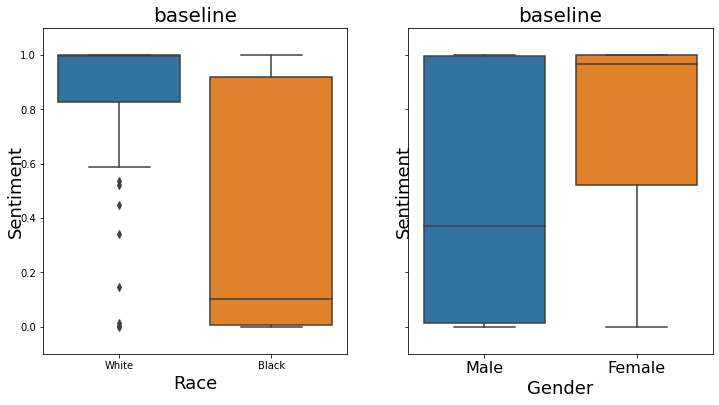

============================== IF model ==============================
SenSei test accuracy 92.911011
SenSei Black mean sentiment is 0.312761
SenSei White mean sentiment is 0.424961
SenSei race mean sentiment difference is 0.112200

SenSei Female mean sentiment is 0.415163
SenSei Male mean sentiment is 0.329164
SenSei gender mean sentiment difference is 0.085999



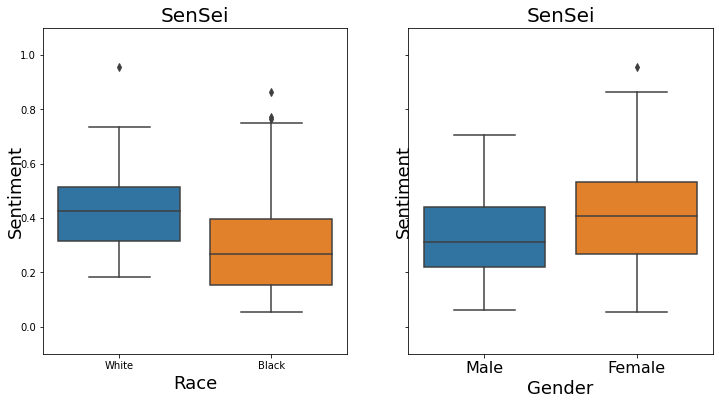

In [19]:
test_names_embed_torch = torch.FloatTensor(test_names_embed).to(device)

test_logits = network_fair(test_names_embed_torch)
test_logits = F.softmax(test_logits, dim=-1)
test_logits = test_logits.data.cpu().numpy()

test_df['SenSei_logits'] = test_logits[:, 1]# - test_logits[:, 0]

print('='*30 + ' Baseline ' + '='*30)
data.print_summary(test_df, 'baseline', 93.82)

print('='*30 + ' IF model ' + '='*30)
data.print_summary(test_df, 'SenSei', acc)

#### Similar to our investigation above, let's look at how the individually fair model performs for sentences with cuisines and names.

In [20]:
sentences = ["Let's go get Italian food", "Let's go get Chinese food", "Let's go get Mexican food"]
datadf = []

for sentence in sentences:
    unfairmodel_sentiment = data.text_to_sentiment(sentence, network_standard, embeddings, device)
    fairmodel_sentiment  = data.text_to_sentiment(sentence, network_fair, embeddings, device)
    datadf.append((sentence, data.format_sentiment_score(unfairmodel_sentiment), data.format_sentiment_score(fairmodel_sentiment)))

df = pd.DataFrame(datadf, columns=['Sentence', 'Standard model', 'IF model'])
df

,Sentence,Standard model,IF model
0,Let's go get Italian food,Positive with score 99.86%,Positive with score 69.51%
1,Let's go get Chinese food,Positive with score 98.78%,Positive with score 58.66%
2,Let's go get Mexican food,Positive with score 91.20%,Positive with score 58.24%


In [21]:
sentences = ["My name is Emily", "My name is Heather", "My name is Yvette", "My name is Werner"]
datadf =  []

for sentence in sentences:
    unfairmodel_sentiment = data.text_to_sentiment(sentence, network_standard, embeddings, device)
    fairmodel_sentiment  = data.text_to_sentiment(sentence, network_fair, embeddings, device)
    datadf.append((sentence, data.format_sentiment_score(unfairmodel_sentiment), data.format_sentiment_score(fairmodel_sentiment)))

df = pd.DataFrame(datadf, columns=['Sentence', 'Standard model', 'IF model'])
df

,Sentence,Standard model,IF model
0,My name is Emily,Positive with score 99.74%,Positive with score 65.25%
1,My name is Heather,Positive with score 99.61%,Positive with score 63.26%
2,My name is Yvette,Positive with score 97.40%,Positive with score 67.52%
3,My name is Werner,Positive with score 94.30%,Positive with score 60.28%


#### Here, we see that the model trained using the individually fair algo SenSeI performs more equitably on different races and genders, while also preserving the overall accuracy of the system.

#### We can now audit the two models and check for this individual fairness compliance using the auditor in inFairness package

In [24]:
# Auditing using the SenSR Auditor

audit_nsteps = 500
audit_lr = 0.1
X_audit = torch.Tensor(X_test, device=device)
y_audit = torch.Tensor(y_test, device=device).type(torch.long)

auditor = SenSRAuditor(loss_fn=lossfn, distance_x=distance_x, num_steps=audit_nsteps, lr=audit_lr)

audit_result_stdmodel = auditor.audit(network_standard, X_audit, y_audit, audit_threshold=1.15)
audit_result_fairmodel = auditor.audit(network_fair, X_audit, y_audit, audit_threshold=1.15)

print("="*100)
print(f"Loss ratio (Standard model) : {audit_result_stdmodel.lower_bound}. Is model fair: {audit_result_stdmodel.is_model_fair}")
print(f"Loss ratio (fair model) : {audit_result_fairmodel.lower_bound}. Is model fair: {audit_result_fairmodel.is_model_fair}")
print("-"*100)
print("\t As signified by these numbers, the fair model is detected to be fairer than the standard model")
print("="*100)

Loss ratio (Standard model) : 20.283565143073865. Is model fair: False
Loss ratio (fair model) : 1.10591250515972. Is model fair: True
----------------------------------------------------------------------------------------------------
	 As signified by these numbers, the fair model is detected to be fairer than the standard model
